## Imports and settings

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import wandb
import math
import torch.nn.functional as F
import os
from torchvision.models import efficientnet_b0
from tqdm import tqdm
import timm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
wandb.init(project="deeplens-pinn", entity="samkitshah1262-warner-bros-discovery",reinit=True)

epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
train_auc,▁▅▆▇▇▇█████████████
train_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_physics_loss,█▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂
val_auc,▁▆▇██▇██▇██████████
val_loss,█▆▂▁▁▂▁▂▄▃▂▄▅▄▅▆▆▆▆
epoch,18
train_auc,0.99903
train_loss,0.25843
train_physics_loss,0.3733
val_auc,0.92422


In [ ]:
# Configuration
class Config:
    SEED = 1
    BATCH_SIZE = 64
    EPOCHS = 150
    LEARNING_RATE = 1e-4
    NUM_CLASSES = 3
    IMG_SIZE = (150, 150)
    USE_SAVED_MODEL = False
    CKPT_PATH = "./model_weights_pinn.pth"

config = Config()

# Set random seeds
torch.manual_seed(config.SEED)
np.random.seed(config.SEED)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# import gdown

# url = "https://drive.google.com/uc?id=1ZEyNMEO43u3qhJAwJeBZxFBEYc_pVYZQ"
# output = "dataset.zip"
# gdown.download(url, output)
# !unzip -q dataset.zip

## Visualization

In [ ]:
set_images_no = []
for i in range(10):
    set_images_no.append(np.load(f"dataset/train/no/{i+1}.npy"))
set_images_sphere = []
for i in range(10):
    set_images_sphere.append(np.load(f"dataset/train/sphere/{i+1}.npy"))
set_images_vortex = []
for i in range(10):
    set_images_vortex.append(np.load(f"dataset/train/vort/{i+1}.npy"))

In [ ]:
img = np.load("dataset/train/no/1.npy")
img = torch.tensor(img, dtype=torch.float32)
img.shape

torch.Size([1, 150, 150])

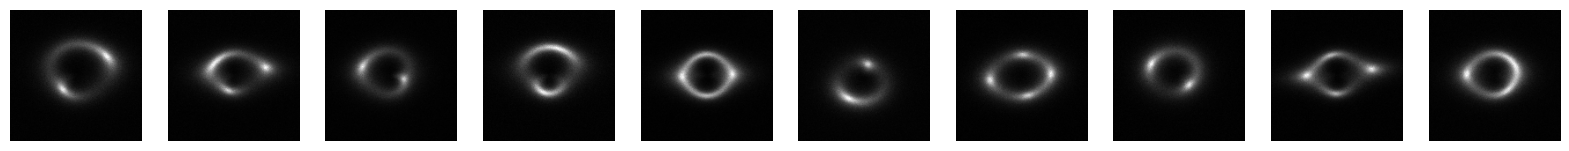

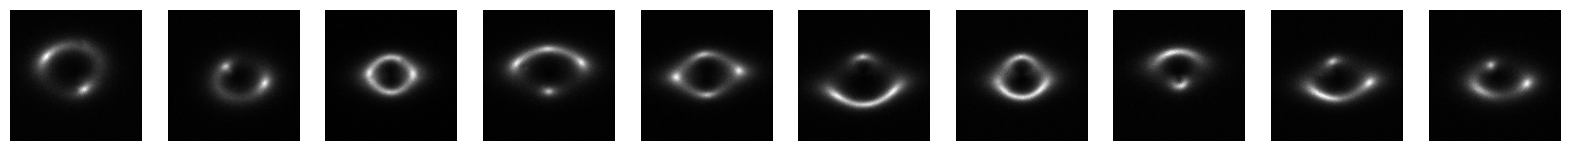

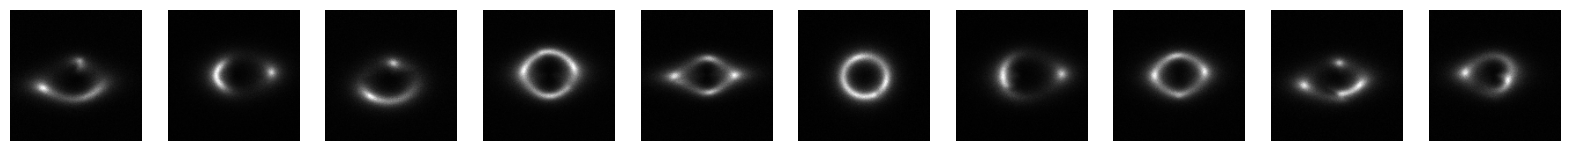

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    axs[i].imshow(set_images_no[i][0], cmap='gray')
    axs[i].axis('off')
plt.show()

fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    axs[i].imshow(set_images_sphere[i][0], cmap='gray')
    axs[i].axis('off')
plt.show()

fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    axs[i].imshow(set_images_vortex[i][0], cmap='gray')
    axs[i].axis('off')

plt.show()

## Data Loading and Processing

In [ ]:
CLASS_MAP = {'no': 0, 'sphere': 1, 'vort': 2}

class DeepLenseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        for class_name, class_label in CLASS_MAP.items():
            class_folder = os.path.join(root_dir, class_name)
            if not os.path.exists(class_folder):
                continue
            for file in os.listdir(class_folder):
                self.samples.append((os.path.join(class_folder, file), class_label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        img = np.load(file_path)
        img = (img - np.mean(img)) / (np.std(img) + 1e-8)
        img = torch.tensor(img, dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label

train_transform = transforms.Compose([
        transforms.Normalize((0.5,), (0.5,))
])

def load_data():
    train_dataset = DeepLenseDataset('dataset/train',transform=train_transform)
    val_dataset = DeepLenseDataset('dataset/val',transform=train_transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0,      pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0,      pin_memory=True)

    return train_loader, val_loader

## Model

In [ ]:
def deltamat(shape):
    kk = np.zeros((shape, shape))
    for i in range(shape):
        for j in range(shape):
            kk[i][j] = np.sqrt((i+1)**2 + (j+1)**2)
    return torch.tensor(kk, dtype=torch.float32)
pos_matrix = deltamat(150).unsqueeze(0).to(device)

In [ ]:
class LensPINN(nn.Module):
    def __init__(self, pos_mat):
        super(LensPINN, self).__init__()
        self.pos_mat = pos_mat
        self.encoder = timm.create_model("efficientnet_b0",
                                       pretrained=False,
                                       in_chans=1,
                                       num_classes=150*150,
                                       drop_rate=0.1)

        self.physics_branch = timm.create_model("efficientnet_b0",
                                              pretrained=False,
                                              in_chans=2,
                                              num_classes=3,
                                              drop_rate=0.1)
    def generate_coord_grid(self, H, W, device):
        xs = torch.linspace(-1, 1, W, device=device)
        ys = torch.linspace(-1, 1, H, device=device)
        grid_y, grid_x = torch.meshgrid(ys, xs, indexing='ij')
        grid = torch.stack([grid_x, grid_y], dim=0)
        return grid.unsqueeze(0)
    
    def lensing_equation(self, coord, theta_E, gamma, phi):
        eps = 1e-6
        batch = coord.size(0)
        theta_E = theta_E.view(batch, 1, 1, 1)
        gamma = gamma.view(batch, 1, 1, 1)
        phi = phi.view(batch, 1, 1, 1)
        norm = torch.sqrt(coord[:,0:1,:,:]**2 + coord[:,1:2,:,:]**2 + eps)
        unit_coord = coord / norm
        defl_SIS = theta_E * unit_coord
        cos2phi = torch.cos(2*phi)
        sin2phi = torch.sin(2*phi)
        theta_x = coord[:,0:1,:,:]
        theta_y = coord[:,1:2,:,:]
        shear_x = cos2phi * theta_x + sin2phi * theta_y
        shear_y = sin2phi * theta_x - cos2phi * theta_y
        defl_shear = gamma * torch.cat([shear_x, shear_y], dim=1)

        beta_pred = coord - defl_SIS - defl_shear
        return beta_pred

    def forward(self, x):
        batch = x.size(0)
        enc_out = self.encoder(x).view(batch, 1, 150, 150)
        ang_dist = enc_out * self.pos_mat
        src_img = x - ang_dist
        two_chan = torch.cat([x, src_img], dim=1)

        params = self.physics_branch(two_chan)
        theta_E, gamma, phi = params[:,0], params[:,1], params[:,2]

        coord_grid = self.generate_coord_grid(150, 150, x.device).repeat(batch, 1, 1, 1)
        beta_pred = self.lensing_equation(coord_grid, theta_E, gamma, phi)

        return params, beta_pred


## Trainer and Validator

In [ ]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    total_samples = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            params, _ = model(inputs)
            loss_cls = criterion(params, labels)
            total_loss += loss_cls.item()
            total_samples += inputs.size(0)
            preds = torch.argmax(F.log_softmax(params, dim=1), dim=1)
            correct += (preds == labels).sum().item()
            total_loss += loss_cls.item()
            all_preds.append(F.log_softmax(params, dim=1).cpu())
            all_labels.append(labels.cpu())

    avg_loss = total_loss / len(dataloader)
    preds = torch.cat(all_preds).numpy()
    val_labels = torch.cat(all_labels).numpy()
    val_labels_onehot = np.eye(config.NUM_CLASSES)[val_labels]
    auc = roc_auc_score(val_labels_onehot, preds, multi_class='ovr')

    return avg_loss, auc

In [ ]:
def train_model(model, train_loader, val_loader):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    mse_criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(),lr=0.00025, weight_decay=1e-5)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                     mode='min',
                                                     factor=0.1,
                                                     patience=5,
                                                     verbose=True,
                                                     )
    best_auc = 0
    best_weights = None

    scaler = torch.amp.GradScaler()
    for epoch in range(config.EPOCHS):
        model.train()
        train_loss = 0
        train_physics_loss = 0
        all_preds = []
        all_labels = []
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config.EPOCHS}')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast(device_type="mps"):
                params, beta_pred  = model(inputs)
                probs = torch.argmax(F.log_softmax(params, dim=1), dim=1)
                loss_cls = criterion(F.log_softmax(params, dim=1), labels)
                if beta_pred is not None:
                    beta_target = torch.zeros_like(beta_pred).to(device)
                    loss_phys = mse_criterion(beta_pred, beta_target)
                    train_physics_loss += loss_phys
                    loss = loss_cls + 0.5 * loss_phys
                else:
                    loss = loss_cls
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            all_preds.append((F.log_softmax(params, dim=1)).detach().cpu())
            all_labels.append(labels.cpu())
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            # break
        train_preds = torch.cat(all_preds).numpy()
        train_labels = torch.cat(all_labels).numpy()
        train_labels_onehot = np.eye(config.NUM_CLASSES)[train_labels]
        train_auc = roc_auc_score(train_labels_onehot, train_preds, multi_class='ovr')

        val_loss, val_auc = evaluate(model, val_loader, criterion)
        scheduler.step(metrics=val_loss)

        if val_auc > best_auc:
            best_auc = val_auc
            best_weights = model.state_dict().copy()
            torch.save(best_weights, config.CKPT_PATH)

        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss/len(train_loader),
            "train_physics_loss": train_physics_loss/len(train_loader),
            "train_auc": train_auc,
            "val_loss": val_loss,
            "val_auc": val_auc
        })

        print(f'Epoch {epoch+1}/{config.EPOCHS}')
        print(f'Train Loss: {train_loss/len(train_loader):.4f} | Train Physics Loss: {train_physics_loss/len(train_loader):.4f} | Train AUC: {train_auc:.4f}')

    model.load_state_dict(torch.load(config.CKPT_PATH))
    return model

In [ ]:
train_loader, val_loader = load_data()

In [ ]:
model = LensPINN(pos_mat=pos_matrix)
model = train_model(model, train_loader, val_loader)

Epoch 1/150: 100%|██████████| 469/469 [03:33<00:00,  2.20it/s, loss=5.2570]


Epoch 1/150
Train Loss: 4.1044 | Train Physics Loss: 5.2839 | Train AUC: 0.5016


Epoch 2/150: 100%|██████████| 469/469 [03:27<00:00,  2.26it/s, loss=5.3070]


Epoch 2/150
Train Loss: 3.3647 | Train Physics Loss: 3.9205 | Train AUC: 0.4970


Epoch 3/150: 100%|██████████| 469/469 [03:32<00:00,  2.21it/s, loss=1.2298]


Epoch 3/150
Train Loss: 1.7525 | Train Physics Loss: 1.0697 | Train AUC: 0.5002


Epoch 4/150: 100%|██████████| 469/469 [03:29<00:00,  2.24it/s, loss=1.2133]


Epoch 4/150
Train Loss: 1.2882 | Train Physics Loss: 0.2612 | Train AUC: 0.4964


Epoch 5/150: 100%|██████████| 469/469 [03:29<00:00,  2.24it/s, loss=1.2531]


Epoch 5/150
Train Loss: 1.2342 | Train Physics Loss: 0.1860 | Train AUC: 0.4998


Epoch 6/150: 100%|██████████| 469/469 [03:28<00:00,  2.25it/s, loss=1.3629]


Epoch 6/150
Train Loss: 1.2255 | Train Physics Loss: 0.1698 | Train AUC: 0.5007


Epoch 7/150: 100%|██████████| 469/469 [03:29<00:00,  2.24it/s, loss=1.3675]


Epoch 7/150
Train Loss: 1.2166 | Train Physics Loss: 0.1597 | Train AUC: 0.5053


Epoch 8/150: 100%|██████████| 469/469 [03:28<00:00,  2.25it/s, loss=1.1057]


Epoch 8/150
Train Loss: 1.2113 | Train Physics Loss: 0.1527 | Train AUC: 0.4976


Epoch 9/150: 100%|██████████| 469/469 [03:30<00:00,  2.23it/s, loss=1.1536]


Epoch 9/150
Train Loss: 1.2136 | Train Physics Loss: 0.1508 | Train AUC: 0.4996


Epoch 10/150: 100%|██████████| 469/469 [03:29<00:00,  2.24it/s, loss=1.2158]


Epoch 10/150
Train Loss: 1.2070 | Train Physics Loss: 0.1371 | Train AUC: 0.4986


Epoch 11/150: 100%|██████████| 469/469 [03:29<00:00,  2.23it/s, loss=1.1826]


Epoch 11/150
Train Loss: 1.2032 | Train Physics Loss: 0.1283 | Train AUC: 0.4976


Epoch 12/150: 100%|██████████| 469/469 [03:29<00:00,  2.24it/s, loss=1.2251]


Epoch 12/150
Train Loss: 1.1886 | Train Physics Loss: 0.1120 | Train AUC: 0.4986


Epoch 13/150: 100%|██████████| 469/469 [03:31<00:00,  2.21it/s, loss=1.1762]


Epoch 13/150
Train Loss: 1.1758 | Train Physics Loss: 0.0964 | Train AUC: 0.4981


Epoch 14/150: 100%|██████████| 469/469 [03:30<00:00,  2.23it/s, loss=1.2003]


Epoch 14/150
Train Loss: 1.1739 | Train Physics Loss: 0.0958 | Train AUC: 0.5015


Epoch 15/150: 100%|██████████| 469/469 [03:30<00:00,  2.23it/s, loss=1.2108]


Epoch 15/150
Train Loss: 1.1726 | Train Physics Loss: 0.0931 | Train AUC: 0.4988


Epoch 16/150: 100%|██████████| 469/469 [03:29<00:00,  2.24it/s, loss=1.1447]


Epoch 16/150
Train Loss: 1.1709 | Train Physics Loss: 0.0930 | Train AUC: 0.5029


Epoch 17/150: 100%|██████████| 469/469 [03:30<00:00,  2.23it/s, loss=1.1738]


Epoch 17/150
Train Loss: 1.1705 | Train Physics Loss: 0.0932 | Train AUC: 0.5034


Epoch 18/150: 100%|██████████| 469/469 [03:29<00:00,  2.24it/s, loss=1.1329]


Epoch 18/150
Train Loss: 1.1711 | Train Physics Loss: 0.0926 | Train AUC: 0.5021


Epoch 19/150: 100%|██████████| 469/469 [03:29<00:00,  2.24it/s, loss=1.1385]


Epoch 19/150
Train Loss: 1.1714 | Train Physics Loss: 0.0926 | Train AUC: 0.5009


Epoch 20/150: 100%|██████████| 469/469 [03:28<00:00,  2.25it/s, loss=1.1627]


Epoch 20/150
Train Loss: 1.1700 | Train Physics Loss: 0.0914 | Train AUC: 0.5032


Epoch 21/150: 100%|██████████| 469/469 [03:29<00:00,  2.24it/s, loss=1.1880]


Epoch 21/150
Train Loss: 1.1719 | Train Physics Loss: 0.0917 | Train AUC: 0.4987


Epoch 22/150: 100%|██████████| 469/469 [03:30<00:00,  2.23it/s, loss=1.2092]


Epoch 22/150
Train Loss: 1.1695 | Train Physics Loss: 0.0912 | Train AUC: 0.5046


Epoch 23/150: 100%|██████████| 469/469 [03:33<00:00,  2.20it/s, loss=1.1942]


Epoch 23/150
Train Loss: 1.1703 | Train Physics Loss: 0.0916 | Train AUC: 0.5019


Epoch 24/150: 100%|██████████| 469/469 [03:31<00:00,  2.21it/s, loss=1.2071]


Epoch 24/150
Train Loss: 1.1695 | Train Physics Loss: 0.0909 | Train AUC: 0.5040


Epoch 25/150: 100%|██████████| 469/469 [03:33<00:00,  2.19it/s, loss=1.1567]


Epoch 25/150
Train Loss: 1.1679 | Train Physics Loss: 0.0919 | Train AUC: 0.5059


Epoch 26/150:  17%|█▋        | 82/469 [00:36<02:54,  2.22it/s, loss=1.1852]


KeyboardInterrupt: 